In [1]:
cd editGAN_release-release_final/

/root/editGAN_release-release_final


In [ ]:
!python get_gradient_map.py ;shutdown

In [ ]:
!python style_test.py

In [ ]:
!python concat_gm.py ;shutdown

100%|█████████████████████████████████████████| 901/901 [18:14<00:00,  1.21s/it]
Layer 3  done
100%|█████████████████████████████████████████| 901/901 [18:22<00:00,  1.22s/it]
Layer 5  done
100%|█████████████████████████████████████████| 901/901 [18:12<00:00,  1.21s/it]
Layer 6  done
100%|█████████████████████████████████████████| 901/901 [18:14<00:00,  1.21s/it]
Layer 8  done
100%|█████████████████████████████████████████| 901/901 [18:14<00:00,  1.21s/it]
Layer 9  done
100%|█████████████████████████████████████████| 901/901 [18:29<00:00,  1.23s/it]
Layer 11  done
100%|█████████████████████████████████████████| 901/901 [09:15<00:00,  1.62it/s]
Layer 12  done
100%|█████████████████████████████████████████| 901/901 [09:14<00:00,  1.62it/s]
Layer 14  done
100%|█████████████████████████████████████████| 901/901 [04:40<00:00,  3.22it/s]
Layer 15  done
100%|█████████████████████████████████████████| 901/901 [04:38<00:00,  3.23it/s]
Layer 17  done
 64%|██████████████████████████              

In [2]:
import numpy as np
l18gm=np.load('../autodl-tmp/s_with_mask/grad_map/Layer18_gm.npy')
print(l18gm.shape)

(901, 64, 32, 32)


In [ ]:
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import dnnlib
import legacy
import time
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [ ]:
#导入旧版网络
device = torch.device('cuda')
with dnnlib.util.open_url("cloth-v2-620t-old.pkl") as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [19]:
#导入新版网络
device = torch.device('cuda')
with dnnlib.util.open_url("cloth-v2-620t-s-test.pkl") as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


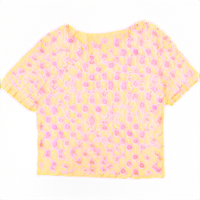

In [20]:
#从文件中初始化ws和ss
ws=np.load("optimized_latent/latents_image_2.npy")
ws=torch.from_numpy(ws).cuda()
img,styles_feature,ss=G.synthesis(ws,return_style=True)
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
ori_im = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))
ori_im

In [ ]:
#随机初始化ws和ss
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to('cuda')
ws = G.mapping(z,0,truncation_psi=0.7)
img,_ = G.synthesis(ws, noise_mode='random')
# img = G(z, 2, truncation_psi=0.7, noise_mode='random')
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
ori_im = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))
ori_im

In [ ]:
#原版注册backward_hook
total_grad = []

def backward_hook(module, grad_in, grad_out):
    total_grad.append(grad_out[0][0])
    #print("len(total_grad):",len(total_grad),"grad_out[0][0].shape:",grad_out[0][0].shape)

back_handle = []
for block_name in G.synthesis._modules:
    for layer_name in G.synthesis._modules[block_name]._modules:
        cur_handle = G.synthesis._modules[block_name]._modules[layer_name].affine.register_backward_hook(backward_hook)
        back_handle.append(cur_handle)
    #         break
#     break
print(len(back_handle))
print(back_handle)

In [ ]:
#test版注册backward_hook 
total_grad = []

def backward_hook(module, grad_in, grad_out):
    print("len(grad_in)",len(grad_in))
    gi1,gi2=grad_in
    print("gi2.shape",gi2.shape)
    print("type(gi2)",type(gi2))
    total_grad.append(grad_out[0][0])

back_handle = []
for block_name in G.synthesis._modules:
    for layer_name in G.synthesis._modules[block_name]._modules:
        cur_handle = G.synthesis._modules[block_name]._modules[layer_name].register_backward_hook(backward_hook)
        back_handle.append(cur_handle)
    #         break
#     break
print(len(back_handle))
print(back_handle)

In [ ]:
#注册forward_hook
#total_grad = []

def forward_hook(module, inp, outp):
    print("len(inp)",len(inp))
    inp1,inp2=inp
    print("inp1.shape",inp1.shape)
    print("inp2.shape",inp2.shape)
    print("len(output)",len(outp))
    outp1,outp2=outp
    print("outp1.shape",outp1.shape)
    print("outp2.shape",outp2.shape)
    
    

forward_handle = []
for block_name in G.synthesis._modules:
    for layer_name in G.synthesis._modules[block_name]._modules:
        cur_handle = G.synthesis._modules[block_name]._modules[layer_name].register_forward_hook(forward_hook)
        forward_handle.append(cur_handle)
    #         break
#     break
print(len(forward_handle))
#print(back_handle)

In [ ]:
for h in forward_handle:
    h.remove()

In [ ]:
for h in back_handle:
    h.remove()

In [8]:
#ws as input
import torch.nn as nn
import os
#from torch.autograd.gradcheck import get_analytical_jacobian,iter_tensors,_compute_analytical_jacobian_rows,_stack_and_check_tensors

import collections
from typing import Callable, Union, Optional, Iterable, List, Tuple, Dict
from torch.overrides import is_tensor_like
def _iter_tensors(x: Union[torch.Tensor, Iterable[torch.Tensor]],
                  only_requiring_grad: bool = False) -> Iterable[torch.Tensor]:
    if is_tensor_like(x):
        # mypy doesn't narrow type of `x` to torch.Tensor
        if x.requires_grad or not only_requiring_grad:  # type: ignore[union-attr]
            yield x  # type: ignore[misc]
    elif isinstance(x, collections.abc.Iterable) and not isinstance(x, str):
        for elem in x:
            for result in _iter_tensors(elem, only_requiring_grad):
                yield result

def _compute_analytical_jacobian_rows(vjp_fn, sample_output) -> List[List[Optional[torch.Tensor]]]:
    # Computes Jacobian row-by-row using backward function `vjp_fn` = v^T J
    # NB: this function does not assume vjp_fn(v) to return tensors with the same
    # number of elements for different v. This is checked when we later combine the
    # rows into a single tensor.
    grad_out_base = torch.zeros_like(sample_output, memory_format=torch.legacy_contiguous_format)#shape=[1,32,32]
    flat_grad_out = grad_out_base.view(-1)#shape=[1024],1024=32*32
    print("flat_grad_out.shape",flat_grad_out.shape)
    # jacobians_rows[i][j] represents the jth row of the ith input
    jacobians_rows: List[List[Optional[torch.Tensor]]] = []
    for j in range(flat_grad_out.numel()):
        flat_grad_out.zero_()
        flat_grad_out[j] = 1.0
        grad_inputs = vjp_fn(grad_out_base)  #grad_inputs=dy/dx 包在两层tuple里，shape=[14×512]
        #print("len(grad_inputs",len(grad_inputs))
        #print("grad_inputs[0][0].shape",grad_inputs[0][0].shape)
        count_grad_inputs=0
        for i, d_x in enumerate(grad_inputs):
            count_grad_inputs+=1
            if j == 0:
                jacobians_rows.append([])
            jacobians_rows[i] += [d_x.clone() if isinstance(d_x, torch.Tensor) else None]
    return jacobians_rows

def get_analytical_jacobian(inputs, output):
    diff_input_list = list(_iter_tensors(inputs, True))#len=1,diff_input_list[0].shape=[1,14,512]  shape[]
    

    def vjp_fn(grad_output):
        return torch.autograd.grad(output, diff_input_list, grad_output,
                                   retain_graph=True, allow_unused=True)
    # Compute everything twice to check for nondeterminism (which we call reentrancy)
    vjps1 = _compute_analytical_jacobian_rows(vjp_fn, output.clone())

    output_numel = output.numel()#用于计算数组中满足指定条件的元素个数。若是一幅图像，则numel(A)将给出它的像素数
    jacobians1, _, _ = _stack_and_check_tensors(vjps1, inputs, output_numel)
    return jacobians1

def _is_float_or_complex_tensor(obj):
    return is_tensor_like(obj) and (obj.is_floating_point() or obj.is_complex())

def _allocate_jacobians_with_inputs(input_tensors: Tuple, numel_output) -> Tuple[torch.Tensor, ...]:
    # Makes zero-filled tensors from inputs. If `numel_output` is not None, for
    # each tensor in `input_tensors`, returns a new zero-filled tensor with height
    # of `t.numel` and width of `numel_output`. Otherwise, for each tensor, returns
    # a 1-d tensor with size `(t.numel,)`. Each new tensor will be strided and have
    # the same dtype and device as those of the corresponding input.
    out: List[torch.Tensor] = []
    for t in input_tensors:
        if _is_float_or_complex_tensor(t) and t.requires_grad:
            out.append(t.new_zeros((t.numel(), numel_output), layout=torch.strided))
    return tuple(out)

def _stack_and_check_tensors(list_of_list_of_tensors, inputs,
                             numel_outputs) -> Tuple[Tuple[torch.Tensor, ...], bool, bool]:
    # For the ith tensor in the inner list checks whether it has the same size and
    # dtype as the ith differentiable input.
    out_jacobians = _allocate_jacobians_with_inputs(inputs, numel_outputs)
    diff_input_list = list(_iter_tensors(inputs, True))
    correct_grad_sizes = True
    correct_grad_types = True
    for i, tensor_list in enumerate(list_of_list_of_tensors):
        inp = diff_input_list[i]
        out_jacobian = out_jacobians[i]
        for j, tensor in enumerate(tensor_list):
            if tensor is not None and tensor.size() != inp.size():
                correct_grad_sizes = False
            elif tensor is not None and tensor.dtype != inp.dtype:
                correct_grad_types = False
            if tensor is None:
                out_jacobian[:, j].zero_()
            else:
                dense = tensor.to_dense() if not tensor.layout == torch.strided else tensor
                assert out_jacobian[:, j].numel() == dense.numel()
                out_jacobian[:, j] = dense.reshape(-1)
    return out_jacobians, correct_grad_sizes, correct_grad_types

start_time = time.time()

#z = torch.from_numpy(np.random.randn(1, G.z_dim)).to('cuda')
#ws = G.mapping(z,0,truncation_psi=0.7)

ws.requires_grad_(True)
total_grad = []
print(ws.shape)

avgpool = nn.AvgPool2d((8, 8), stride=(8, 8))
output,_ = G.synthesis(ws,noise_mode='const')
output_resize = avgpool(output)#shape=[1,3,32,32]
img1 = (output_resize.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
ori_im1 = PIL.Image.fromarray(img1[0].cpu().numpy(), 'RGB').resize((200,200))

res = get_analytical_jacobian(ws,output_resize[:,0,:,:])#output_resize[:,0,:,:].shape=[1,32,32]

print("total_cost1:",time.time() - start_time)
print("total_output_size1:", len(total_grad) / len(back_handle),len(back_handle))

total_grad_cpu=[]
for i in range(len(total_grad)):
    total_grad_cpu.append(total_grad[i].cpu())
    
    
total_grad_cpu = np.array((total_grad_cpu))


# total_grad = []
# res = get_analytical_jacobian(ws,output_resize[:,1,:,:])#output_resize[:,0,:,:].shape=[1,32,32]

# print("total_cost2:",time.time() - start_time)
# print("total_output_size2:", len(total_grad) / len(back_handle),len(back_handle))

# total_grad_cpu=[]
# for i in range(len(total_grad)):
#     total_grad_cpu.append(total_grad[i].cpu())
    
    
# grad2 = np.array((total_grad_cpu))
# total_grad = []
# res3 = get_analytical_jacobian(ws,output_resize[:,2,:,:])#output_resize[:,0,:,:].shape=[1,32,32]

# print("total_cost3:",time.time() - start_time)
# print("total_output_size3:", len(total_grad) / len(back_handle),len(back_handle))

# total_grad_cpu=[]
# for i in range(len(total_grad)):
#     total_grad_cpu.append(total_grad[i].cpu())
    
    
# grad3 = np.array((total_grad_cpu))

for h in back_handle:
   h.remove()


torch.Size([1, 14, 512])
flat_grad_out.shape torch.Size([1024])
total_cost1: 18.673694610595703
total_output_size1: 1024.0 20


/tmp/ipykernel_16430/3014847616.py:127: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  total_grad_cpu = np.array((total_grad_cpu))
/tmp/ipykernel_16430/3014847616.py:127: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  total_grad_cpu = np.array((total_grad_cpu))


In [35]:
#ss as input
import torch.nn as nn
import os

import collections
from typing import Callable, Union, Optional, Iterable, List, Tuple, Dict
from torch.overrides import is_tensor_like
def _iter_tensors(x: Union[torch.Tensor, Iterable[torch.Tensor]],
                  only_requiring_grad: bool = False) -> Iterable[torch.Tensor]:
    if is_tensor_like(x):
        # mypy doesn't narrow type of `x` to torch.Tensor
        if x.requires_grad or not only_requiring_grad:  # type: ignore[union-attr]
            yield x  # type: ignore[misc]
    elif isinstance(x, collections.abc.Iterable) and not isinstance(x, str):
        for elem in x:
            for result in _iter_tensors(elem, only_requiring_grad):
                yield result

def _compute_analytical_jacobian_rows(vjp_fn, sample_output) -> List[List[Optional[torch.Tensor]]]:
    # Computes Jacobian row-by-row using backward function `vjp_fn` = v^T J
    # NB: this function does not assume vjp_fn(v) to return tensors with the same
    # number of elements for different v. This is checked when we later combine the
    # rows into a single tensor.
    grad_out_base = torch.zeros_like(sample_output, memory_format=torch.legacy_contiguous_format)#shape=[1,32,32]
    flat_grad_out = grad_out_base.view(-1)#shape=[1024],1024=32*32
    print("flat_grad_out.shape",flat_grad_out.shape)
    # jacobians_rows[i][j] represents the jth row of the ith input
    jacobians_rows: List[List[Optional[torch.Tensor]]] = []
    grad_map=[]
    for j in range(flat_grad_out.numel()):
        flat_grad_out.zero_()
        flat_grad_out[j] = 1.0
        grad_inputs = vjp_fn(grad_out_base)  #grad_inputs=dy/dx
        #print("len(grad_inputs)",grad_inputs)
        #count_grad_inputs=0
        for i, d_x in enumerate(grad_inputs):
            #count_grad_inputs+=1
            #if j == 0:
                #jacobians_rows.append([])
            #jacobians_rows[i] += [d_x.clone() if isinstance(d_x, torch.Tensor) else None]
            grad_map.append(d_x.clone().squeeze())
    #return jacobians_rows
    return grad_map

def get_analytical_jacobian(inputs, output):
    diff_input_list = list(_iter_tensors(inputs, True))#len=1,diff_input_list[0].shape=[1,14,512]
    

    def vjp_fn(grad_output):
        return torch.autograd.grad(output, diff_input_list, grad_output,
                                   retain_graph=True, allow_unused=True)
    # Compute everything twice to check for nondeterminism (which we call reentrancy)
    vjps1 = _compute_analytical_jacobian_rows(vjp_fn, output.clone())

    #output_numel = output.numel()#用于计算数组中满足指定条件的元素个数。若是一幅图像，则numel(A)将给出它的像素数
    #jacobians1, _, _ = _stack_and_check_tensors(vjps1, inputs, output_numel)
    #return jacobians1
    return vjps1

def _is_float_or_complex_tensor(obj):
    return is_tensor_like(obj) and (obj.is_floating_point() or obj.is_complex())

def _allocate_jacobians_with_inputs(input_tensors: Tuple, numel_output) -> Tuple[torch.Tensor, ...]:
    # Makes zero-filled tensors from inputs. If `numel_output` is not None, for
    # each tensor in `input_tensors`, returns a new zero-filled tensor with height
    # of `t.numel` and width of `numel_output`. Otherwise, for each tensor, returns
    # a 1-d tensor with size `(t.numel,)`. Each new tensor will be strided and have
    # the same dtype and device as those of the corresponding input.
    out: List[torch.Tensor] = []
    for t in input_tensors:
        if _is_float_or_complex_tensor(t) and t.requires_grad:
            out.append(t.new_zeros((t.numel(), numel_output), layout=torch.strided))
    return tuple(out)

def _stack_and_check_tensors(list_of_list_of_tensors, inputs,
                             numel_outputs) -> Tuple[Tuple[torch.Tensor, ...], bool, bool]:
    # For the ith tensor in the inner list checks whether it has the same size and
    # dtype as the ith differentiable input.
    out_jacobians = _allocate_jacobians_with_inputs(inputs, numel_outputs)
    diff_input_list = list(_iter_tensors(inputs, True))
    correct_grad_sizes = True
    correct_grad_types = True
    for i, tensor_list in enumerate(list_of_list_of_tensors):
        inp = diff_input_list[i]
        out_jacobian = out_jacobians[i]
        for j, tensor in enumerate(tensor_list):
            if tensor is not None and tensor.size() != inp.size():
                correct_grad_sizes = False
            elif tensor is not None and tensor.dtype != inp.dtype:
                correct_grad_types = False
            if tensor is None:
                out_jacobian[:, j].zero_()
            else:
                dense = tensor.to_dense() if not tensor.layout == torch.strided else tensor
                assert out_jacobian[:, j].numel() == dense.numel()
                out_jacobian[:, j] = dense.reshape(-1)
    return out_jacobians, correct_grad_sizes, correct_grad_types

start_time = time.time()

#z = torch.from_numpy(np.random.randn(1, G.z_dim)).to('cuda')
#ws = G.mapping(z,0,truncation_psi=0.7)

#ws.requires_grad_(True)

for i in range(len(ss)):
    ss[i].requires_grad_(True)
total_grad = []
#print(ws.shape)

avgpool = nn.AvgPool2d((8, 8), stride=(8, 8))
#output,_ = G.synthesis(ws, noise_mode='const')
output,styles_feature,all_styles=G.synthesis(None,return_style=True,use_styles=True,input_styles=ss,noise_mode='const')
output_resize = avgpool(output)#shape=[1,3,32,32]
img1 = (output_resize.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
ori_im1 = PIL.Image.fromarray(img1[0].cpu().numpy(), 'RGB').resize((200,200))

res = get_analytical_jacobian(ss,output_resize[:,0,:,:])#output_resize[:,0,:,:].shape=[1,32,32]
s_total_grad_cpu=[]
for i in range(len(res)):
    s_total_grad_cpu.append(res[i].cpu())
s_total_grad_cpu = np.array((s_total_grad_cpu))

res1 = get_analytical_jacobian(ss,output_resize[:,1,:,:])#output_resize[:,0,:,:].shape=[1,32,32]
s_total_grad_cpu1=[]
for i in range(len(res1)):
    s_total_grad_cpu1.append(res1[i].cpu())
s_total_grad_cpu1 = np.array((s_total_grad_cpu1))


res2 = get_analytical_jacobian(ss,output_resize[:,2,:,:])#output_resize[:,0,:,:].shape=[1,32,32]
s_total_grad_cpu2=[]
for i in range(len(res2)):
    s_total_grad_cpu2.append(res2[i].cpu())
s_total_grad_cpu2 = np.array((s_total_grad_cpu2))

print("total_cost1:",time.time() - start_time)



flat_grad_out.shape torch.Size([1024])


/tmp/ipykernel_355/3359258314.py:122: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  s_total_grad_cpu = np.array((s_total_grad_cpu))
/tmp/ipykernel_355/3359258314.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s_total_grad_cpu = np.array((s_total_grad_cpu))


flat_grad_out.shape torch.Size([1024])


/tmp/ipykernel_355/3359258314.py:128: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  s_total_grad_cpu1 = np.array((s_total_grad_cpu1))
/tmp/ipykernel_355/3359258314.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s_total_grad_cpu1 = np.array((s_total_grad_cpu1))


flat_grad_out.shape torch.Size([1024])
total_cost1: 49.80918025970459


/tmp/ipykernel_355/3359258314.py:135: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  s_total_grad_cpu2 = np.array((s_total_grad_cpu2))
/tmp/ipykernel_355/3359258314.py:135: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s_total_grad_cpu2 = np.array((s_total_grad_cpu2))


In [21]:
#ss as input,grad_y=[1,1,1]
import torch.nn as nn
import os

import collections
from typing import Callable, Union, Optional, Iterable, List, Tuple, Dict
from torch.overrides import is_tensor_like
def _iter_tensors(x: Union[torch.Tensor, Iterable[torch.Tensor]],
                  only_requiring_grad: bool = False) -> Iterable[torch.Tensor]:
    if is_tensor_like(x):
        # mypy doesn't narrow type of `x` to torch.Tensor
        if x.requires_grad or not only_requiring_grad:  # type: ignore[union-attr]
            yield x  # type: ignore[misc]
    elif isinstance(x, collections.abc.Iterable) and not isinstance(x, str):
        for elem in x:
            for result in _iter_tensors(elem, only_requiring_grad):
                yield result

def _compute_analytical_jacobian_rows(vjp_fn, sample_output) -> List[List[Optional[torch.Tensor]]]:
    # Computes Jacobian row-by-row using backward function `vjp_fn` = v^T J
    # NB: this function does not assume vjp_fn(v) to return tensors with the same
    # number of elements for different v. This is checked when we later combine the
    # rows into a single tensor.
    grad_out_base = torch.zeros_like(sample_output, memory_format=torch.legacy_contiguous_format)#shape=[1,32,32]
    flat_grad_out = grad_out_base.view(-1)#shape=[1024],1024=32*32
    print("flat_grad_out.shape",flat_grad_out.shape)
    # jacobians_rows[i][j] represents the jth row of the ith input
    jacobians_rows: List[List[Optional[torch.Tensor]]] = []
    grad_map=[]
    for j in range(1024):
        flat_grad_out.zero_()
        flat_grad_out[j] = 1.0
        flat_grad_out[j+1024] = 1.0
        flat_grad_out[j+2048] = 1.0
        grad_inputs = vjp_fn(grad_out_base)  #grad_inputs=dy/dx
        #print("len(grad_inputs)",grad_inputs)
        #count_grad_inputs=0
        for i, d_x in enumerate(grad_inputs):
            #count_grad_inputs+=1
            #if j == 0:
                #jacobians_rows.append([])
            #jacobians_rows[i] += [d_x.clone() if isinstance(d_x, torch.Tensor) else None]
            grad_map.append(d_x.clone().squeeze())
    #return jacobians_rows
    return grad_map

def get_analytical_jacobian(inputs, output):
    diff_input_list = list(_iter_tensors(inputs, True))#len=1,diff_input_list[0].shape=[1,14,512]
    

    def vjp_fn(grad_output):
        return torch.autograd.grad(output, diff_input_list, grad_output,
                                   retain_graph=True, allow_unused=True)
    # Compute everything twice to check for nondeterminism (which we call reentrancy)
    vjps1 = _compute_analytical_jacobian_rows(vjp_fn, output.clone())

    #output_numel = output.numel()#用于计算数组中满足指定条件的元素个数。若是一幅图像，则numel(A)将给出它的像素数
    #jacobians1, _, _ = _stack_and_check_tensors(vjps1, inputs, output_numel)
    #return jacobians1
    return vjps1

def _is_float_or_complex_tensor(obj):
    return is_tensor_like(obj) and (obj.is_floating_point() or obj.is_complex())

def _allocate_jacobians_with_inputs(input_tensors: Tuple, numel_output) -> Tuple[torch.Tensor, ...]:
    # Makes zero-filled tensors from inputs. If `numel_output` is not None, for
    # each tensor in `input_tensors`, returns a new zero-filled tensor with height
    # of `t.numel` and width of `numel_output`. Otherwise, for each tensor, returns
    # a 1-d tensor with size `(t.numel,)`. Each new tensor will be strided and have
    # the same dtype and device as those of the corresponding input.
    out: List[torch.Tensor] = []
    for t in input_tensors:
        if _is_float_or_complex_tensor(t) and t.requires_grad:
            out.append(t.new_zeros((t.numel(), numel_output), layout=torch.strided))
    return tuple(out)

def _stack_and_check_tensors(list_of_list_of_tensors, inputs,
                             numel_outputs) -> Tuple[Tuple[torch.Tensor, ...], bool, bool]:
    # For the ith tensor in the inner list checks whether it has the same size and
    # dtype as the ith differentiable input.
    out_jacobians = _allocate_jacobians_with_inputs(inputs, numel_outputs)
    diff_input_list = list(_iter_tensors(inputs, True))
    correct_grad_sizes = True
    correct_grad_types = True
    for i, tensor_list in enumerate(list_of_list_of_tensors):
        inp = diff_input_list[i]
        out_jacobian = out_jacobians[i]
        for j, tensor in enumerate(tensor_list):
            if tensor is not None and tensor.size() != inp.size():
                correct_grad_sizes = False
            elif tensor is not None and tensor.dtype != inp.dtype:
                correct_grad_types = False
            if tensor is None:
                out_jacobian[:, j].zero_()
            else:
                dense = tensor.to_dense() if not tensor.layout == torch.strided else tensor
                assert out_jacobian[:, j].numel() == dense.numel()
                out_jacobian[:, j] = dense.reshape(-1)
    return out_jacobians, correct_grad_sizes, correct_grad_types

start_time = time.time()

#z = torch.from_numpy(np.random.randn(1, G.z_dim)).to('cuda')
#ws = G.mapping(z,0,truncation_psi=0.7)

#ws.requires_grad_(True)

for i in range(len(ss)):
    ss[i].requires_grad_(True)
total_grad = []
#print(ws.shape)

avgpool = nn.AvgPool2d((8, 8), stride=(8, 8))
#output,_ = G.synthesis(ws, noise_mode='const')
output,styles_feature,all_styles=G.synthesis(None,return_style=True,use_styles=True,input_styles=ss,noise_mode='const')
output_resize = avgpool(output)#shape=[1,3,32,32]
img1 = (output_resize.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
ori_im1 = PIL.Image.fromarray(img1[0].cpu().numpy(), 'RGB').resize((200,200))

res = get_analytical_jacobian(ss,output_resize[:,:,:,:])#output_resize[:,0,:,:].shape=[1,32,32]
s_total_grad_cpu=[]
for i in range(len(res)):
    s_total_grad_cpu.append(res[i].cpu())
s_total_grad_cpu = np.array((s_total_grad_cpu))



print("total_cost1:",time.time() - start_time)



flat_grad_out.shape torch.Size([3072])
total_cost1: 18.020200967788696


/tmp/ipykernel_208/2466739564.py:124: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  s_total_grad_cpu = np.array((s_total_grad_cpu))
/tmp/ipykernel_208/2466739564.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s_total_grad_cpu = np.array((s_total_grad_cpu))


In [ ]:
print(s_total_grad_cpu[0])#输出为512维 

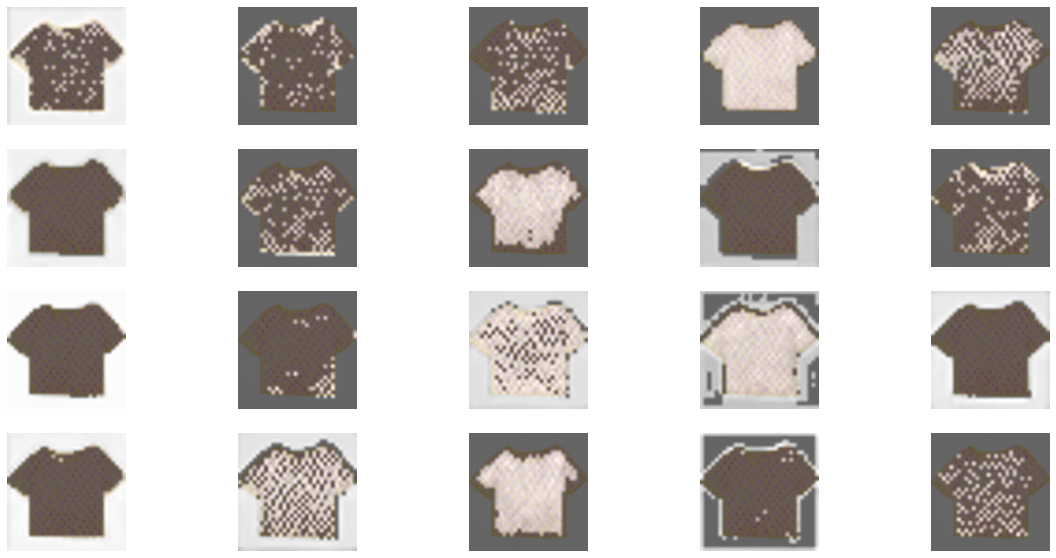

In [11]:
#打印梯度图
%matplotlib inline
import  matplotlib.pyplot as plt
from PIL import Image
plt.figure(figsize=(20,10))
plt.axis("off")
index = 3 #第几个s
for k in range(20): #k表示s的第几个通道
    
#     grad = res[0][0][i+512 * 3]
#     grad = grad.detach().cpu().numpy()
#     img = Image.fromarray(np.uint8(np.where(grad.reshape(32,32) > 0,0,255))).resize((200,200))
#     gradient_map = np.array([grad[26*i + index][k] for i in range(1024)])
    gradient_map = np.array([s_total_grad_cpu[20*i + 19 - index][k].detach().cpu().numpy() for i in range(1024)])#1024=32*32
    #print(gradient_map.shape)

    gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
    gradient_binary_map = np.uint8(np.where(gradient_heat_map > 150 ,gradient_heat_map,0))
    
#     gradient_im = Image.fromarray(gradient_heat_map).resize((200,200))
    gradient_im = Image.fromarray(gradient_binary_map).resize((200,200))
    
    gradient_blend = Image.blend(gradient_im.convert("RGB"),ori_im,0.4)


#     index = i + 512 * 0
#     grad = np.array([i[index].detach().cpu().numpy() for i in total_grad])
#     img = Image.fromarray(np.uint8(np.where(grad.reshape(32,32) > -0.002 ,0,255))).resize((200,200))
#     res = Image.blend(img.convert("RGB"),ori_im,0.5)
    
    plt.subplot(4,5,k+1)
    plt.axis("off")
    plt.imshow(gradient_blend)

#os.system("shutdown")

In [24]:
index = 3 #第几个s
for k in range(1): #k表示s的第几个通道

    gradient_map = np.array([s_total_grad_cpu[20*i + 19 - index][k].detach().cpu().numpy() for i in range(1024)])#1024=32*32
    #print(gradient_map.shape)

    gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
    #gradient_binary_map = np.uint8(np.where(gradient_heat_map > 150 ,gradient_heat_map,0))
    #gradient_im=gradient_heat_map.clone()
    np.save("../autodl-tmp/grad_map/test.npy",gradient_heat_map)
    #gradient_im = Image.fromarray(gradient_binary_map).resize((200,200))
    #gradient_blend = Image.blend(gradient_im.convert("RGB"),ori_im,0.4)
    

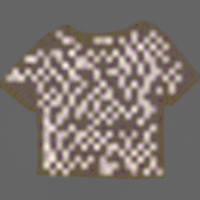

In [29]:
index = 3 #第几个s
#for k in range(1): #k表示s的第几个通道

gradient_map = np.array([s_total_grad_cpu[20*i + 19 - index][0].detach().cpu().numpy() for i in range(1024)])#1024=32*32
#print(gradient_map.shape)

gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
gradient_binary_map = np.uint8(np.where(gradient_heat_map > 150 ,gradient_heat_map,0))
#gradient_im=gradient_heat_map.clone()
#np.save("../autodl-tmp/grad_map/test.npy",gradient_heat_map)
gradient_im = Image.fromarray(gradient_binary_map).resize((200,200))
gradient_blend = Image.blend(gradient_im.convert("RGB"),ori_im,0.4)
gradient_blend

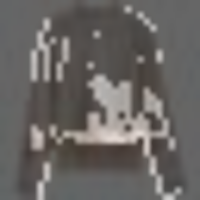

In [12]:
from PIL import Image

#im_fr = np.load("../autodl-tmp/grad_map/test.npy",allow_pickle=True)
im_fr = np.load("../autodl-tmp/s_with_mask/grad_map/0/Layer0/L0_C0.npy",allow_pickle=True)
ori_im = Image.open("../autodl-tmp/s_with_mask/grad_map/0/orig.jpg").resize((200,200))

im_frame = np.uint8(np.where(im_fr > 150 ,im_fr,0))
gradient_im=Image.fromarray(im_frame).resize((200,200))
#gradient_im
gradient_blend = Image.blend(gradient_im.convert("RGB"),ori_im.convert("RGB"),0.4)
gradient_blend

In [3]:
from PIL import Image
import numpy as np
im_fr = np.load("../autodl-tmp/s_with_mask/grad_map/0/Layer0/L0_C0.npy",allow_pickle=True)
print(im_fr.shape)

(32, 32)


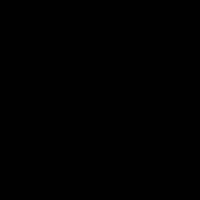

In [34]:
test_allone_array=np.uint8(np.ones((32,32)))
gradient_im=Image.fromarray(test_allone_array).resize((200,200))
gradient_im

In [39]:
a=[[1,1,1],[0,0,0],[1,1,1]]
b=[[0,0,0],[1,3,1],[0,5,0]]
c=[[2,2,2],[1,1,1],[0,0,3]]
maxdata=np.maximum(np.maximum(a,b),c)
print(maxdata)

[[2 2 2]
 [1 3 1]
 [1 5 3]]


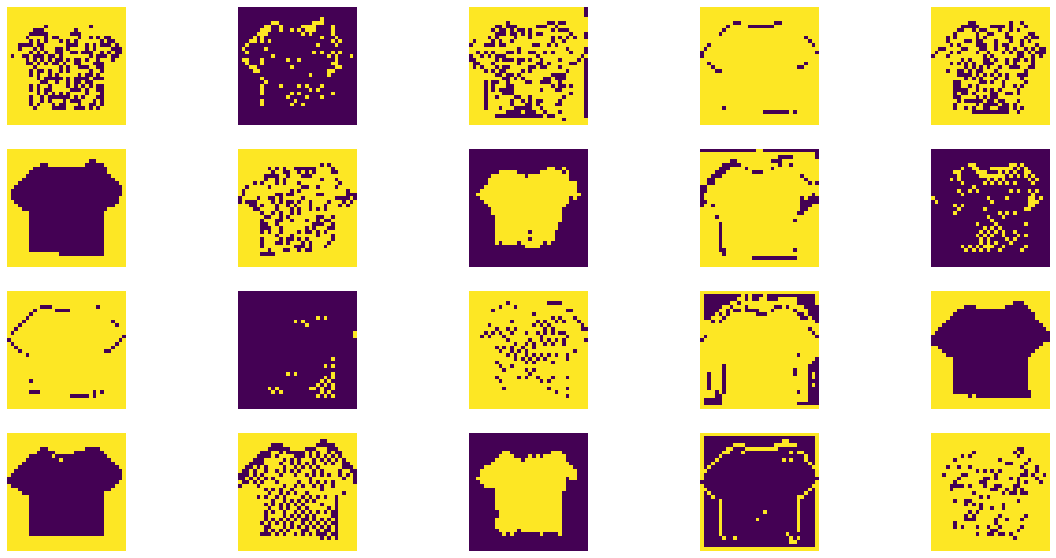

In [43]:
%matplotlib inline
import  matplotlib.pyplot as plt
from PIL import Image
plt.figure(figsize=(20,10))
plt.axis("off")
index = 3 #第几个s
for k in range(20): #k表示s的第几个通道
    
    gradient_map = np.array([s_total_grad_cpu[20*i + 19 - index][k].detach().cpu().numpy() for i in range(1024)])#1024=32*32
    gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
    gradient_binary_map1 = np.uint8(np.where(gradient_heat_map > 150 ,1,0))
    
    gradient_map = np.array([s_total_grad_cpu1[20*i + 19 - index][k].detach().cpu().numpy() for i in range(1024)])#1024=32*32
    gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
    gradient_binary_map2 = np.uint8(np.where(gradient_heat_map > 150 ,1,0))
    
    gradient_map = np.array([s_total_grad_cpu2[20*i + 19 - index][k].detach().cpu().numpy() for i in range(1024)])#1024=32*32
    gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
    gradient_binary_map3 = np.uint8(np.where(gradient_heat_map > 150 ,1,0))
    
    
    
    gradient_binary_map=np.maximum(np.maximum(gradient_binary_map1,gradient_binary_map2),gradient_binary_map3)
    gradient_im = Image.fromarray(gradient_binary_map).resize((200,200))
    #gradient_blend = Image.blend(gradient_im.convert("RGB"),ori_im,0.4)

    
    plt.subplot(4,5,k+1)
    plt.axis("off")
    plt.imshow(gradient_binary_map)

#os.system("shutdown")

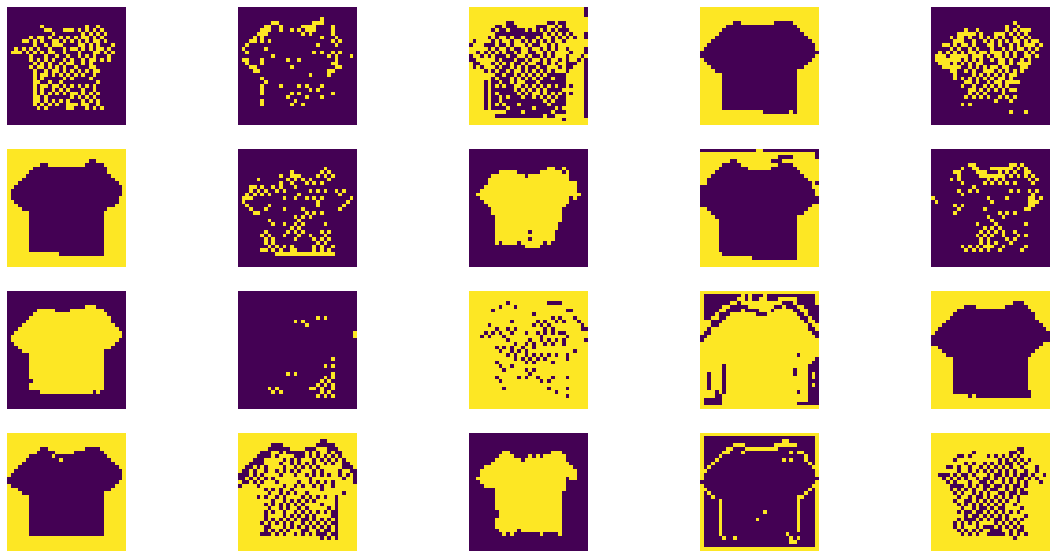

In [45]:
%matplotlib inline
import  matplotlib.pyplot as plt
from PIL import Image
plt.figure(figsize=(20,10))
plt.axis("off")
index = 3 #第几个s
for k in range(20): #k表示s的第几个通道
    
    gradient_map = np.array([s_total_grad_cpu[20*i + 19 - index][k].detach().cpu().numpy() for i in range(1024)])#1024=32*32
    gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
    gradient_binary_map = np.uint8(np.where(gradient_heat_map > 150 ,1,0))
    
    gradient_im = Image.fromarray(gradient_binary_map).resize((200,200))
    #gradient_blend = Image.blend(gradient_im.convert("RGB"),ori_im,0.4)

    
    plt.subplot(4,5,k+1)
    plt.axis("off")
    plt.imshow(gradient_binary_map)

#os.system("shutdown")


In [46]:
gradient_map = np.array([s_total_grad_cpu[20*i + 19 - 3][0].detach().cpu().numpy() for i in range(1024)])#1024=32*32
gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
gradient_binary_map = np.uint8(np.where(gradient_heat_map > 150 ,1,0))
gradient_im = Image.fromarray(gradient_binary_map).resize((200,200))
gradient_binary_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [71]:
for i in range(len(ss)):
    print(i,ss[i].shape)

0 torch.Size([1, 512])
1 torch.Size([1, 512])
2 torch.Size([1, 512])
3 torch.Size([1, 512])
4 torch.Size([1, 512])
5 torch.Size([1, 512])
6 torch.Size([1, 512])
7 torch.Size([1, 512])
8 torch.Size([1, 512])
9 torch.Size([1, 512])
10 torch.Size([1, 512])
11 torch.Size([1, 512])
12 torch.Size([1, 256])
13 torch.Size([1, 256])
14 torch.Size([1, 256])
15 torch.Size([1, 128])
16 torch.Size([1, 128])
17 torch.Size([1, 128])
18 torch.Size([1, 64])
19 torch.Size([1, 64])


In [70]:
ss_c3=[]
ss_c7=[]

img,styles_feature,ss_c3=G.synthesis(ws,return_style=True)
img,styles_feature,ss_c7=G.synthesis(ws,return_style=True)

print("ss_c3_before",ss_c3[16][0][3])
ss_c3[16][0][3]+=4.
print("ss_c3_after",ss_c3[16][0][3])
print(ss_c7[16][0][7])
ss_c7[16][0][7]+=4.
print(ss_c7[16][0][7])
output_orig,_,_=G.synthesis(None,return_style=True,use_styles=True,input_styles=ss,noise_mode='const')
img1 = (output_orig.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
PIL.Image.fromarray(img1[0].cpu().numpy(), 'RGB').save("../autodl-tmp/grad_map/orig.jpg")

output_3,_,_=G.synthesis(None,return_style=True,use_styles=True,input_styles=ss_c3,noise_mode='const')
img2 = (output_3.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
PIL.Image.fromarray(img2[0].cpu().numpy(), 'RGB').save("../autodl-tmp/grad_map/i3c3.jpg")

output_7,_,_=G.synthesis(None,return_style=True,use_styles=True,input_styles=ss_c7,noise_mode='const')
img3 = (output_7.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
PIL.Image.fromarray(img3[0].cpu().numpy(), 'RGB').save("../autodl-tmp/grad_map/i3c7.jpg")


ss_c3_before tensor(-0.0894, device='cuda:0')
ss_c3_after tensor(3.9106, device='cuda:0')
tensor(-0.0446, device='cuda:0')
tensor(3.9554, device='cuda:0')


In [2]:
from PIL import Image
im_frame = Image.open('../autodl-tmp/s_with_mask/mask/0.png')
mask = im_frame.resize((32,32))
mask.save('../autodl-tmp/s_with_mask/mask_32/0.png')
im_32=Image.open('../autodl-tmp/s_with_mask/mask_32/0.png')
print(im_frame.size,im_32.size)
print(im_32)

(256, 256) (32, 32)
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FB8DC1DF340>


In [5]:
import numpy as np
im_frame = np.load('../autodl-tmp/s_with_mask/grad_map/0/Layer0/L0_C0.npy',allow_pickle=True)

#np_im=np.array(im_32)

print(im_frame.dtype)

uint8
